In [44]:
import numpy as np
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [45]:
%reload_ext autoreload
%autoreload 2

In [46]:
def convert_date(str):
    """
    This method is used to convert a string into datetime.
    """
    arr = str.split("-")
    year = int(arr[0])
    month = int(arr[1])

    str = arr[2]
    arr = str.split()
    day = int(arr[0])
    date = datetime.datetime(year = year, month = month, day = day)
    return date

## Get Data

In [47]:
data = pd.read_csv("data/train.csv")
test = pd.read_csv('data/test.csv')
display(data.head())
display(test.head())

,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
0,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,0.000000,1079,1.079000e+03,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:15:39,cash,0.000,no ID,Pumpkins
1,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,0.290,0.000000,2032,2.032000e+03,Orange navel,0.0,2.99,2016-03-16 23:15:39,cash,0.000,no ID,Citrus
2,f4dd518d-1fd8-4339-abc6-2c5390c20e30,-1.000,0.000000,2032,2.032000e+03,Orange navel,0.0,2.99,2016-03-16 23:17:35,cashrefund,0.000,NaN,Citrus
3,aa299de6-1332-48ba-bce9-de8cbb48741e,3.292,10.909091,1001,1.001000e+03,Australian Asparagus green,2.0,2.70,2016-03-16 23:19:47,cash,39.504,no ID,Bunch Vegies
4,aa299de6-1332-48ba-bce9-de8cbb48741e,1.000,0.000000,4019,8.888101e+12,Nice Munchee 200g,0.9,1.50,2016-03-16 23:19:47,cash,39.504,no ID,Sri Lankan Groceries


,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
0,7394a47a-778b-4299-bc0b-204c803204fd,1.980,1.99,2010,2010.0,Banana Cavendish,2.00,1.99,2019-01-02 08:09:57,cash,3.95020,no ID,Bananas
1,17079ce3-7a0b-4fbb-a762-977a3ae79667,1.000,1.50,1049,1049.0,Lettuce Iceberg,0.00,2.50,2019-01-02 08:34:09,cash,14.49868,no ID,Lettuces
2,17079ce3-7a0b-4fbb-a762-977a3ae79667,0.170,2.00,1071,1071.0,Potato brushed,2.25,2.50,2019-01-02 08:34:09,cash,14.49868,no ID,Potatoes
3,17079ce3-7a0b-4fbb-a762-977a3ae79667,1.044,2.50,1078,1078.0,Pumpkin Butternut,0.00,1.99,2019-01-02 08:34:09,cash,14.49868,no ID,Pumpkins
4,17079ce3-7a0b-4fbb-a762-977a3ae79667,0.724,1.99,2003,2003.0,Apples Pink Lady,0.00,2.99,2019-01-02 08:34:09,cash,14.49868,no ID,Apples


## Column selection and categorization

In [48]:
data = data.loc[data['CATERGORY'] == 'Pumpkins']
data

,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
0,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,0.0,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:15:39,cash,0.00000,no ID,Pumpkins
9,4b5e95b3-8a90-4e3a-8bf4-688c47f3b042,3.290,0.0,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:35:25,cash,1.45000,no ID,Pumpkins
132,c787c6a0-6b58-464f-b085-d3165bf95879,3.608,0.9,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-17 11:31:46,cash,19.35540,no ID,Pumpkins
140,a150c94c-d988-4cb1-9b83-45f6d6d154b9,2.346,0.9,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2016-03-17 11:38:57,cash,10.41156,no ID,Pumpkins
202,a03ed49b-1609-47b4-ba39-38c1313c0bf8,1.852,2.0,1078,1078.0,Pumpkin Butternut,0.0,1.99,2016-03-17 12:20:52,cash,15.72464,no ID,Pumpkins
...,...,...,...,...,...,...,...,...,...,...,...,...,...
529473,87873c2c-0ad1-40dc-87eb-35f40ac41097,1.050,1.9,1080,1080.0,Pumpkin Grey,0.0,1.99,2018-12-31 09:42:49,cash,7.45072,no ID,Pumpkins
529529,92ad24e6-7d31-4afd-a35b-96b19bd6ca78,1.370,1.9,1080,1080.0,Pumpkin Grey,0.0,1.99,2018-12-31 10:44:00,cash,20.69844,no ID,Pumpkins
529687,5ae24124-3536-40c3-8dea-1ea2cd2625e9,0.978,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2018-12-31 12:48:36,cash,18.90196,no ID,Pumpkins
529826,ec7c744f-72ae-464f-add1-7c7231200cc6,0.780,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2018-12-31 15:15:52,cash,2.74786,no ID,Pumpkins


### Sort by date and assign number to it

In [49]:
date = data['DATENEW'].apply(convert_date)
date

0        2016-03-16
9        2016-03-16
132      2016-03-17
140      2016-03-17
202      2016-03-17
            ...    
529473   2018-12-31
529529   2018-12-31
529687   2018-12-31
529826   2018-12-31
529955   2018-12-31
Name: DATENEW, Length: 11378, dtype: datetime64[ns]

In [50]:
data['DATENEW'] = date
data = data[["DATENEW", "TOTAL"]].groupby('DATENEW').sum().reset_index()
data = data.sort_values(by = "DATENEW", ascending = True)
data

,DATENEW,TOTAL
0,2016-03-16,1.45000
1,2016-03-17,94.85804
2,2016-03-18,58.46096
3,2016-03-19,59.14820
4,2016-03-20,149.73492
...,...,...
995,2018-12-24,283.55150
996,2018-12-28,81.39328
997,2018-12-29,141.51224
998,2018-12-30,200.33340


## Building Model

In [51]:
test = test.loc[test['CATERGORY'] == 'Pumpkins']
test

,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
3,17079ce3-7a0b-4fbb-a762-977a3ae79667,1.044,2.5,1078,1078.0,Pumpkin Butternut,0.0,1.99,2019-01-02 08:34:09,cash,14.49868,no ID,Pumpkins
26,95ab7fce-1164-48a2-8783-0977dfde35ae,0.830,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-01-02 09:16:44,cash,8.85466,no ID,Pumpkins
46,1c35de1f-da99-4a7e-83be-c5cbbbb723d7,0.694,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-01-02 09:19:19,cash,5.80472,no ID,Pumpkins
115,b418994a-69c6-4d57-b944-07cd16d76370,1.830,1.2,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-01-02 10:36:07,cash,16.44860,no ID,Pumpkins
147,3ae20864-cf50-42a8-b15e-431c6cd4da03,1.268,2.5,1078,1078.0,Pumpkin Butternut,0.0,1.99,2019-01-02 11:02:24,cash,3.15000,no ID,Pumpkins
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129040,e63e7306-912a-4bd7-9100-29a0b9d04533,0.912,2.4,1078,1078.0,Pumpkin Butternut,0.0,1.99,2019-10-13 11:31:03,cash,12.09880,no ID,Pumpkins
129138,bc0f97ca-efb5-404a-8927-416aad1976b2,0.806,1.5,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-10-13 14:12:01,cash,3.64556,no ID,Pumpkins
129188,668fc6a3-40ec-4af7-9188-bf94895675e4,0.992,1.5,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-10-13 16:01:22,magcard,30.40102,880304475478,Pumpkins
129201,1648444a-ea34-4da5-964e-b31c2922cfe7,1.686,1.5,1079,1079.0,Pumpkin Japanese/Kent,0.0,1.99,2019-10-13 16:04:03,cash,12.75100,no ID,Pumpkins


In [52]:
date = test['DATENEW'].apply(convert_date)
test['DATENEW'] = date
test = test[["DATENEW", "TOTAL"]].groupby('DATENEW').sum().reset_index()
test = test.sort_values(by = "DATENEW", ascending = True)
test

,DATENEW,TOTAL
0,2019-01-02,247.593636
1,2019-01-03,157.284620
2,2019-01-04,115.867900
3,2019-01-05,243.441340
4,2019-01-06,242.508600
...,...,...
272,2019-10-09,109.759000
273,2019-10-10,106.839760
274,2019-10-11,169.811460
275,2019-10-12,206.466960


In [53]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [54]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
sale_series = data['TOTAL']
# transform data to be stationary
train_raw_values = sale_series.values
diff_values = difference(train_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
train = supervised.values

sale_series = test['TOTAL']
# transform data to be stationary
test_raw_values = sale_series.values
diff_values = difference(test_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
test = supervised.values

In [75]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
train_prediction = lstm_model.predict(train_reshaped, batch_size=1)
rmse = np.sqrt(mean_squared_error(train_raw_values[:-1], train_prediction))
print('train rmse:' + str(rmse))

train rmse:189.0999619074583


In [76]:
# cross validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(test_raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = test_raw_values[i]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=218.528545, Expected=247.593636
Predicted=170.560029, Expected=157.284620
Predicted=144.244429, Expected=115.867900
Predicted=210.829316, Expected=243.441340
Predicted=209.025621, Expected=242.508600
Predicted=162.823799, Expected=156.148045
Predicted=108.026645, Expected=61.498484
Predicted=151.027898, Expected=152.305980
Predicted=131.145015, Expected=119.492260
Predicted=125.227517, Expected=116.894780
Predicted=90.232904, Expected=58.564000
Predicted=116.487292, Expected=118.256300
Predicted=82.838677, Expected=60.656320
Predicted=85.756280, Expected=76.936700
Predicted=60.131442, Expected=36.505020
Predicted=64.306040, Expected=54.900900
Predicted=102.272561, Expected=132.745580
Predicted=199.102240, Expected=304.793940
Predicted=113.342189, Expected=141.604140
Predicted=157.301534, Expected=226.915920
Predicted=109.850784, Expected=135.694380
Predicted=148.218825, Expected=208.945240
Predicted=114.738941, Expected=144.199600
Predicted=147.426165, Expected=205.656316
Pre

Test RMSE: 48.016


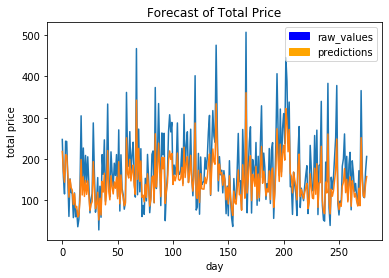

In [77]:
# report performance
rmse = np.sqrt(mean_squared_error(test_raw_values[:-1], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_raw_values[:-1])
plt.plot(predictions)
blue_patch = mpatches.Patch(color='blue', label='raw_values')
orange_patch = mpatches.Patch(color='orange', label='predictions')
plt.legend(handles=[blue_patch, orange_patch])
plt.ylabel('total price')
plt.xlabel('day')
plt.title('Forecast of Total Price')
plt.show()